# **Image Classification**

### About the Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

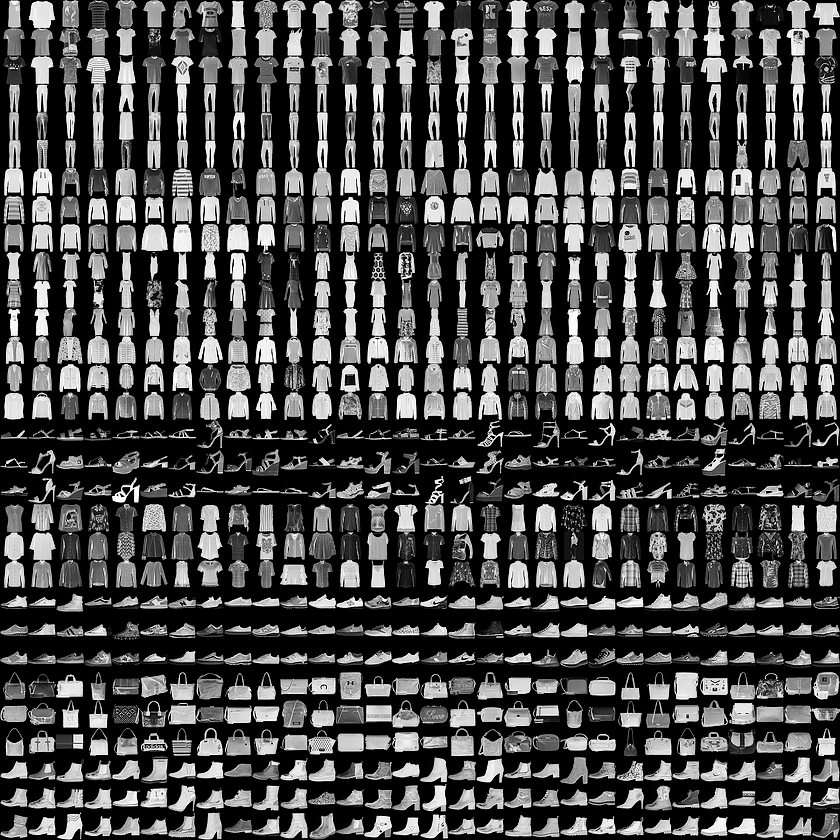

In [5]:
# importing the libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets
from torchvision import transforms
from torch import nn, optim

In [6]:
# check the version of pytorch
print(torch.__version__)

1.8.1+cu101


##**Data Augmentation**

Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

Common Techniques

1. Image Flipping
2. Image Blur
3. Image Rotation


In [8]:
from skimage import io
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt

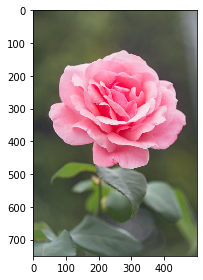

In [9]:
image = io.imread('sample_flower.jpeg')
io.imshow(image)

## **Rotating the Image by 45 Degrees**

Rotated Image


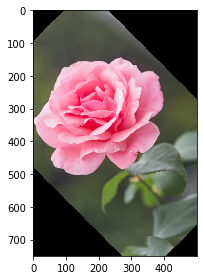

In [10]:
print("Rotated Image")
rotated = rotate(image, angle=45)
io.imshow(rotated)

## **Flip Image left-to-right**

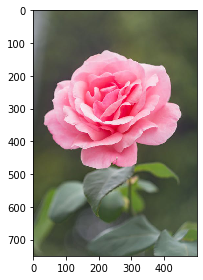

In [11]:
flipLR = np.fliplr(image)

io.imshow(flipLR)

## **Blur the Image**

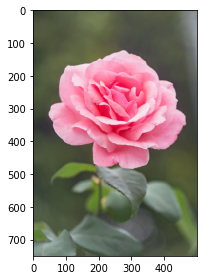

In [13]:
blurred = gaussian(image = image, sigma = 1, multichannel = True)
io.imshow(blurred)

In [14]:
import PIL

In [16]:
# **Transforms** are common image transformations.

# Transforms can be Image Resize, converting an image tensor or the augmentation techniques we have seen above. 

# -> All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input.


# **transform.Compose** clubs all the transforms provided to it. All the transforms in the transforms.Compose are applied to the input one by one.

# Transforms are done on batches and randomly based on the probability provided by us for that specific transformation.

transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p = 0.5),
                transforms.RandomVerticalFlip(p = 0.5),
                transforms.GaussianBlur(3, sigma=(0.1,2.0)),
                transforms.RandomRotation(45, resample = PIL.Image.BILINEAR)     
             ]) 

## Data Preprocessing


In [ ]:
trainset = datasets.FashionMNIST("./data", download = True, train = True, transform = transforms )

testset = datasets.FashionMNIST("./data", download = True, train = False, transform = transforms )

In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [20]:
len(trainset), len(testset)

(60000, 10000)

## **Visualizing the Training Images**

In [24]:
data_iter = iter(trainloader)

image,labels = data_iter.next()
print(image.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


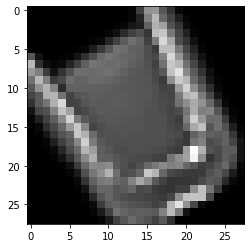

In [26]:
plt.imshow(images[2].numpy().squeeze(), cmap='gray')

### PyTorch Model


In [45]:
class Model(nn.Module):

    def __init__(self):
        
        super(Model, self).__init__()

        self.cnn_layers = nn.Sequential(
                              # one input chanel because of gray scale
                              # 4 output because of 4 filters
                              nn.Conv2d(1, 4, kernel_size = 3, stride = 1, padding = 1),
                              nn.BatchNorm2d(4),
                              nn.ReLU(inplace = True),
                              nn.MaxPool2d(kernel_size = 2, stride = 2),
                              nn.Conv2d(4, 4, kernel_size = 3, stride = 1, padding = 1),
                              nn.BatchNorm2d(4),
                              nn.ReLU(inplace = True),
                              nn.MaxPool2d(kernel_size = 2, stride = 2),  
                                                          
                          )
        
        self.linear_layers = nn.Sequential(
                                  # first is image size, 10 is output
                                  nn.Linear(4*7*7, 10)
                             )
        
    def forward(self, x):
        
        x = self.cnn_layers(x)
        x  = x.view(x.size(0), -1)
        x = self.linear_layers(x)

        return x

In [46]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

criterion = nn.CrossEntropyLoss()


if torch.cuda.is_available():
    print("Will use CuDa")
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Will use CuDa
Model(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


### Training 


Epoch 1 - Training Loss : 0.9991864674508191
Epoch 2 - Training Loss : 0.835908429931476
Epoch 3 - Training Loss : 0.807110114837252
Epoch 4 - Training Loss : 0.7860512714396154
Epoch 5 - Training Loss : 0.772277241544937
Epoch 6 - Training Loss : 0.7666132670602819
Epoch 7 - Training Loss : 0.7663411018309563
Epoch 8 - Training Loss : 0.7609494786653945
Epoch 9 - Training Loss : 0.7551827509202429
Epoch 10 - Training Loss : 0.746348140812886


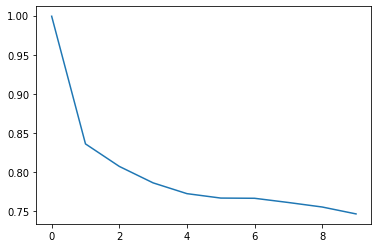

In [47]:
loss_values = []
for i in range(0,10):

    running_loss = 0

    for images,labels in trainloader:
          
          if torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()

          optimizer.zero_grad()

          output = model.forward(images)
          loss = criterion(output, labels)

          loss.backward()

          optimizer.step()

          running_loss += loss.item() 

    else:
        print(f"Epoch {i+1} - Training Loss : {running_loss/len(trainloader)}")
        loss_values.append(running_loss/len(trainloader))

# Plotting the loss
plt.plot(loss_values)

## Results

Getting Predictions on test set and measuring the performance

In [48]:
correct_count = 1
all_count = 0

for images, labels in testloader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        img = images[i].view(1,1,28,28)
        with torch.no_grad():
            logps= model.forward(img)

        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]

        if(true_label == pred_label):
            correct_count += 1

        all_count +=1

print(f"Model accuracy is {correct_count/all_count}")

Model accuracy is 0.6493
